# WIMP limit example

This small example shows how to set a very basic cross-section vs WIMP mass limit. 

We will
  * assume the asymptotic approximation (Wilks' theorem) for the test statistic distribution is accurate;
  * compute one-sided results, i.e. just upper limits, no matter how many WIMPs are observed;
  * have the flat ER background rate as the only nuisance parameter.

In [1]:
!wget -nc https://raw.githubusercontent.com/FlamTeam/flamedisx-notebooks/master/_if_on_colab_setup_flamedisx.ipynb
%run _if_on_colab_setup_flamedisx.ipynb

Flamedisx is installed :-)


In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from tqdm import tqdm

import flamedisx as fd

The helper function below creates a flamedisx likelihood for one WIMP mass.

We will use flamedisx's default settings. These are not especially meaningful, and may have changed by the time you read this notebook. Currently, they are set to:
  * ~2 tonne fiducial mass (all of XENON1T without cuts);
  * 1 year live time;
  * 100 events/keV flat ER background, so roughly 50 events/(tonne year keV)

We'll also inherit from the XENON1T SR0 sources, to get a few other settings (like ER yields) roughly like they were used in XENON1T's first science run (1705.06655). We did not compare these models to the SR0 datasets in detail -- don't think you can use them to do any real science!

Because we'd like this notebook to run even if you only have a CPU, we'll **scale down the exposure by a factor 50**. If you have a GPU, patience, or both, just set the exposure scale to 1. If you have a GPU, you'll also want to increase the default batch size, e.g. to 100 or more -- as large as your card can handle.

In [3]:
exposure_scale = 0.02

def make_likelihood(wimp_mass, data=None, exposure_scale=1):

    class MySource:        
        # Stupid, silly way to scale the exposure...
        # You should really change the expected energy spectra
        # and the t_start and stop attributes.
        def s2_acceptance(self, s2):
            return tf.ones_like(s2) * exposure_scale
    
    class MyWIMP(MySource, fd.SR0WIMPSource):
        mw = wimp_mass
        
    class MyER(MySource, fd.SR0ERSource):
        pass

    return fd.LogLikelihood(
        sources=dict(er=MyER, wimp=MyWIMP),
        data=data,
        progress=False,
        # If you have a GPU, set an appropriate batch size here:
        # batch_size = 100,
        free_rates=('er', 'wimp'))

Let's pre-create the likelihoods for a set of WIMP masses. This isn't strictly necessary for this simple example, but helps to give you an idea how long different operations take.

In particular, the likelihood creation below takes roughly a minute, because we must estimate the expected number of events after efficiencies by Monte Carlo simulation. See section III.B in the [flamedsix paper](https://arxiv.org/pdf/2003.12483.pdf) for more info. This isn't sped up by GPUs, but you only need to do it once.

In [4]:
masses = np.array([10, 14, 20, 30, 40, 50, 70, 100, 140, 200])

likelihoods = {mw: make_likelihood(mw, exposure_scale=exposure_scale)
               for mw in tqdm(masses, desc='Precreating likelihoods...')}

Precreating likelihoods...: 100%|██████████| 10/10 [00:57<00:00,  5.71s/it]


Let's simulate and plot a fake dataset. This will be quick.

Text(0, 0.5, 'cS2 [PE]')

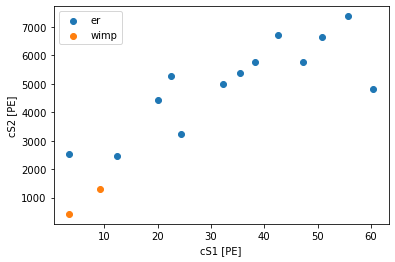

In [5]:
# True WIMP mass in GeV/c^2 and cross section in cm^2
true_mass = 50      # GeV/c^2
true_cross = 1e-45  # cm^2

ll = likelihoods[true_mass]
df = ll.simulate(wimp_rate_multiplier=true_cross/fd.WIMPEnergySpectrum.sigma_nucleon)

for label, d in df.groupby('source'):
    plt.scatter(d['cs1'], d['cs2'], label=label)

plt.legend(loc='upper left')
plt.xlabel("cS1 [PE]")
plt.ylabel("cS2 [PE]")

Now let's make ourselves some WIMP limits. This is where GPU speedups kick in. You'll also notice the computation time scales with the dataset size -- unless the dataset is smaller than your batch size, of course.

In [6]:
limits = np.zeros(len(masses))

for i, mw in enumerate(tqdm(masses)):
    ll = likelihoods[mw]
    ll.set_data(df)

    limits[i] = ll.limit('wimp_rate_multiplier')

# Convert from rate multiplier ('scale factor') to cross-section
limits *= fd.WIMPEnergySpectrum.sigma_nucleon

100%|██████████| 10/10 [00:44<00:00,  4.48s/it]


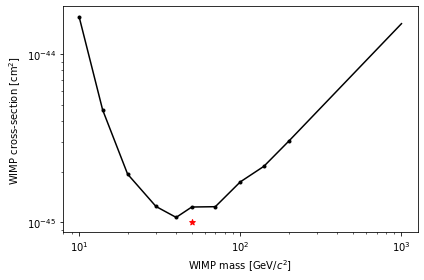

In [7]:
plt.plot(masses, limits, c='k', marker='.')

# Above 200 GeV, limit should scale (roughtly) with mass
ms = np.geomspace(200, 1e3, 100)
limit_200 = limits[-1]
plt.plot(ms, limit_200 * ms/200, c='k')

if true_cross > 0:
    plt.scatter([true_mass], [true_cross], marker='*', c='r')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("WIMP mass [$\mathrm{GeV}/c^2$]")
plt.ylabel("WIMP cross-section [$\mathrm{cm}^2$]")

plt.tight_layout()
plt.savefig('example_limit.png', dpi=200)

The red star shows the true WIMP model (unless you set the cross-section to 0). The limit should be above this 90% of the time you run the notebook... if Wilks' theorem is accurate for this data!

## Testing Wilks

It is straightforward to test if Wilks holds for this particular WIMP model: simulate many toy datasets and compute the profile likelihood test statistic. 

We'll just do 20 trials to give you an idea. To get any kind of real test of Wilks, you'll want to do many more trials -- maybe 100 or 1000 trials if you care only about 90% confidence limits.

In [8]:
ll = likelihoods[true_mass]
true_mult = true_cross/fd.WIMPEnergySpectrum.sigma_nucleon

n_trials = int(20)
ts = np.zeros(n_trials)

for i in tqdm(range(n_trials), desc='Testing Wilks'):
    df = ll.simulate(wimp_rate_multiplier=true_mult)
    ll.set_data(df)

    bestfit = ll.bestfit(guess=dict(wimp_rate_multiplier=true_mult))
    conditional_fit = ll.bestfit(fix=dict(wimp_rate_multiplier=true_mult),
                                 guess=dict(er_rate_multiplier=bestfit['er_rate_multiplier']))

    ts[i] = -2 * (ll(**conditional_fit) - ll(**bestfit))

Testing Wilks: 100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


(0.0, 8.0)

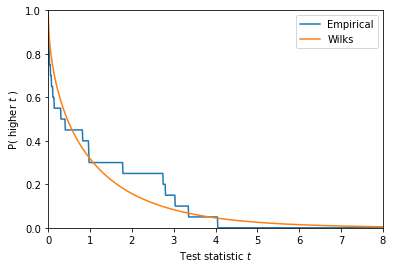

In [9]:
_t = np.linspace(0, 8, 1000)

# Empirical survival function: fraction of ts that are higher
esf = (ts[:,None] > _t[None,:]).mean(axis=0)
plt.plot(_t, esf, label='Empirical')

plt.plot(_t, stats.chi2(1).sf(_t), label='Wilks')

plt.xlabel("Test statistic $t$")
plt.ylabel("P( higher $t$ )")
plt.legend(loc='upper right')
plt.ylim(0, 1)
plt.xlim(_t[0], _t[-1])